# Importing the libraries needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig
from tensorflow import keras

sns.set()

In [2]:
from huggingface_hub import notebook_login

notebook_login()

# Analyzing and preparing the data

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format) # Show 2 numbers after the dot

In [4]:
df = pd.read_csv('./datasets/Limpios/reviews_GoogleYelp_text_tokens.csv')

C:\Users\Luis\AppData\Local\Temp\ipykernel_6616\1496002590.py:1: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./datasets/Limpios/reviews_GoogleYelp_text_tokens.csv')


It´s necessary to find out the number of words in the reviews, so the model will work efficiently and won´t crash the computer.

We create two new columns: one with the text splitted in a list and the other with the total words in that splitted list.

In [5]:
df['splitted_text'] = df['text'].apply(lambda x: x.split())
df['count_words'] = df['splitted_text'].apply(lambda x: len(x))

In [6]:
num_word_description = df['count_words'].describe(percentiles = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
num_word_description

count   1776886.00
mean         41.60
std          63.10
min           1.00
10%           3.00
20%           5.00
30%           8.00
40%          12.00
50%          18.00
60%          27.00
70%          40.00
80%          62.00
90%         108.00
100%       1330.00
max        1330.00
Name: count_words, dtype: float64

We plot the number of words to see the distribution

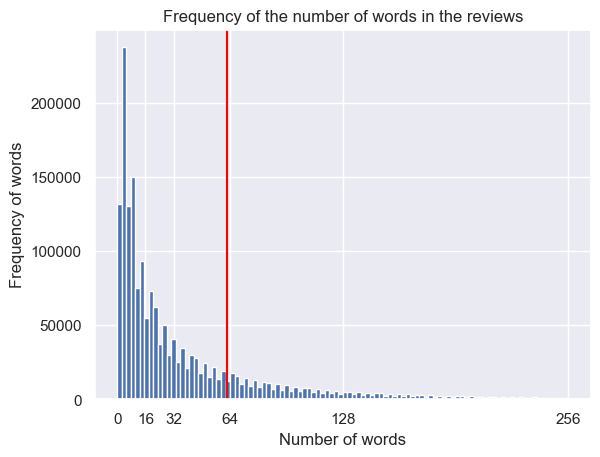

In [7]:
ax = plt.gca()
df['count_words'].plot.hist(xticks = [0, 16, 32, 64, 128, 256], bins = 100, range = [0, 256]).axvline(x = num_word_description['80%'], c = 'red')
plt.xlabel("Number of words")
plt.ylabel("Frequency of words")
plt.title("Frequency of the number of words in the reviews")

plt.show()

With the plot, it´s clear that with the 80% of the rows it's enough and we'll have a good result in the model. The number of words chosen is 64, since it´s a best practice to use numbers powers of 2

In [8]:
df = df[df['count_words'] <= 64]

The model will need to know which reviews are positive, negative, and neutral. With that in mind, the data will be divided into three groups:



1.   Positive if the rating is greater than 3
2.   Neutral if the rating is 3
3.   Negative if the rating is less than 3

In [9]:
def map_rating_to_sentiment(rating):
    if rating > 3:
        return 2  # positive
    elif rating == 3:
        return 1  # neutral
    else:
        return 0  # negative

df['sentiment'] = df['rating'].apply(map_rating_to_sentiment)

Let´s see the distribution of the data in the sentiment column. First we create a df that has the total amount of each sentiment in the original df

In [10]:
positive = df[df['sentiment'] == 2].shape[0]
negative = df[df['sentiment'] == 0].shape[0]
neutral = df[df['sentiment'] == 1].shape[0]

sentiment_dict = {'sentiment': ['positive', 'negative', 'neutral'],'count': [positive, negative, neutral]}

sentiment_df = pd.DataFrame(sentiment_dict)

sentiment_df.set_index('sentiment', inplace = True)

Plot the sentiment_df values to see the distribution of each sentiment

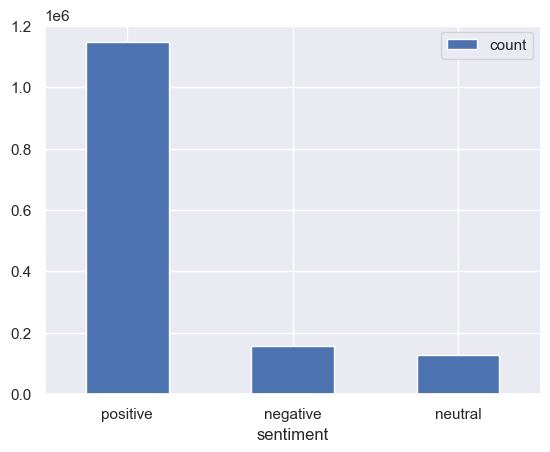

In [11]:
sentiment_df.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

It´s clear that there are more positive reviews than negative or neutral, so the data is skewed. We need to balance the data so the model won't bias the predictions

In [12]:
# Create a df with the minimum value of the different sentiments.

df_0 = df[df['sentiment'] == 0]
df_1 = df[df['sentiment'] == 1]
df_2 = df[df['sentiment'] == 2]

min_rows = min(len(df_0), len(df_1), len(df_2))

df_0_sampled = df_0.sample(min_rows)
df_1_sampled = df_1.sample(min_rows)
df_2_sampled = df_2.sample(min_rows)


final_df = pd.concat([df_0_sampled, df_1_sampled, df_2_sampled])

Next, check the distribution of the new df

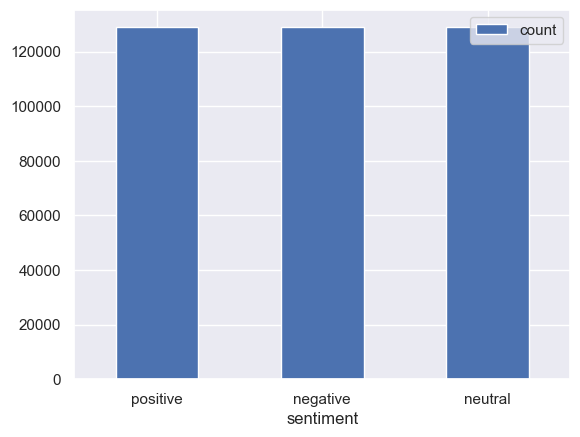

In [13]:
positive = final_df[final_df['sentiment'] == 2].shape[0]
negative = final_df[final_df['sentiment'] == 0].shape[0]
neutral = final_df[final_df['sentiment'] == 1].shape[0]

sentiment_dict = {'sentiment': ['positive', 'negative', 'neutral'],'count': [positive, negative, neutral]}

sentiment_df = pd.DataFrame(sentiment_dict)

sentiment_df.set_index('sentiment', inplace = True)

sentiment_df.plot(kind = 'bar')
plt.xticks(rotation = 0)
plt.show()

It´s clear that the data is balanced and we can use it to train the model

In [14]:
sample_df = final_df.sample(n = 10000, random_state = 123)

# Preparing the data

DistilBert it´s going to be used for the sentiment analysis, so when a new review is loaded, the restaurant will know if it´s a positive, neutral or negative review.

In [15]:
# Create the tokenizer and the model objects

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 3)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [16]:
# Split the dataset into train and test sets

train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=123)

train_texts = train_df["text"].values
train_labels = train_df["sentiment"].values

test_texts = test_df["text"].values
test_labels = test_df["sentiment"].values

In [17]:
# Tokenize and convert the text to tensors

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length = 128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length = 128)

In [18]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

# Train, evaluate and deploy the model to Huggingface Hub

The PushToHubCallback let us push the model to huggingface hub while is training. We´ll use this method to upload the model while is training.

In [19]:
from transformers import PushToHubCallback

callbacks = [PushToHubCallback("model_output_indata/", 
                               tokenizer=tokenizer,
                               hub_model_id="Bert_sentiment_analysis_Indata")]

c:\Users\Luis\Documents\Universidad-Trabajo\SoyHenry\LABS\proyecto_final\model_output_indata is already a clone of https://huggingface.co/luissgtorres/Bert_sentiment_analysis_Indata. Make sure you pull the latest changes with `repo.git_pull()`.


In [20]:
# Train and evaluate the model
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

model.compile(optimizer = optimizer, loss = loss, metrics = [metric])
model.fit(train_dataset.shuffle(100).batch(32), epochs=3, batch_size=32, callbacks = callbacks)

results = model.evaluate(test_dataset.batch(32), return_dict=True)
print(results)

Epoch 1/3
250/250 [==============================] - 24006s 96s/step - loss: 0.7670 - accuracy: 0.6560
Epoch 2/3
250/250 [==============================] - 18396s 74s/step - loss: 0.5570 - accuracy: 0.7691
Epoch 3/3
63/63 [==============================] - 1988s 32s/step - loss: 0.5847 - accuracy: 0.7465
{'loss': 0.5846691131591797, 'accuracy': 0.7465000152587891}


In [21]:
# One last commit so we are sure that the model is correctly uploaded

model.push_to_hub("Bert_sentiment_analysis_Indata", commit_message="End of training") 

Change the labels that will appear in the Huggingface hub, so that the information makes sense

In [22]:
labels = ['negative', 'neutral', 'positive']

model.config.id2label = {str(i): lbl for i, lbl in enumerate(labels)}
model.config.label2id = {lbl: str(i) for i, lbl in enumerate(labels)}

repo_name = "Bert_sentiment_analysis_Indata"
model.config.push_to_hub(repo_name)

CommitInfo(commit_url='https://huggingface.co/luissgtorres/Bert_sentiment_analysis_Indata/commit/2b31bd0375582c744b5339f6a3baeaf212d260ae', commit_message='Upload config', commit_description='', oid='2b31bd0375582c744b5339f6a3baeaf212d260ae', pr_url=None, pr_revision=None, pr_num=None)